# Analysis of CIFAR-10 Spectrum

In this notebook we analyze the spectrum of the covariance matrix of the CIFAR-10 training data set, following section two of "A Solveable Model of Neural Scaling Laws" by Maloney, Roberts, and Sully.  
The log-log plots of the spectrum of eigenvalues of the covariance matrix of the data manifest that the input data obeys a power law falloff for much of the spectrum (in particular in the regime of the most important features).
This power law in the natural data is upstream of the power law improvement in the loss in the training phase, something which we illustrate, following their section three, elsewhere in this repository.
We also augment the spectral analysis in the paper with an ordinary PCA analysis to see how many features are needed to reconstruct the images at a level a human can discern.

In [ ]:
#%%

import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

import torch
import torchvision
import torchvision.transforms as transforms


"""
This script is dedicated to reproducing the various non-trivial figures in the paper "A Solvable Model of Neural Scaling Laws"
by Alexander Maloney, Daniel A. Roberts, and James Sullyde. 
"""

"""
First we load CIFAR-10.  This a database of 50k 32x32 pixel images where each pixel has three color channels.
The images are tagged with one of ten labels.
"""

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
#%%

full_train_data = []
full_train_labels = []

for data, labels in trainloader:
    full_train_data.append(data)
    full_train_labels.append(labels)

full_train_data = torch.cat(full_train_data, dim=0)
full_train_labels = torch.cat(full_train_labels, dim=0)
flat_cifar = full_train_data.view(50000, 32*32*3)

print(full_train_data.shape)  # Output: torch.Size([50000, 3, 32, 32])
print(full_train_labels.shape)  # Output: torch.Size([50000])

torch.Size([50000, 3, 32, 32])
torch.Size([50000])


## Covariance Matrix and Spectral Analysis

With the flatted cifar input data $X^\alpha_i$ with $\alpha$ the image label and $i$ the pixel label, we can construct the covariance matrix
\begin{align*}
C_{ij} = X^\alpha_i X^\alpha_j
\end{align*}
which is of course manifestly Hermitian and so we pass it to `lin.eigvalsh` to obtain the eigenvalue spectrum.\\
We do this considering all $N = 3072$ input features but for various dataset sizes $T$ and find that of course the number of eigenvalues is limited by $T$, which sets the rank of covariance matrix. More obviously, we find similar behavior for fixed data set size $T = 3072$ and varying the number of input features $N$.

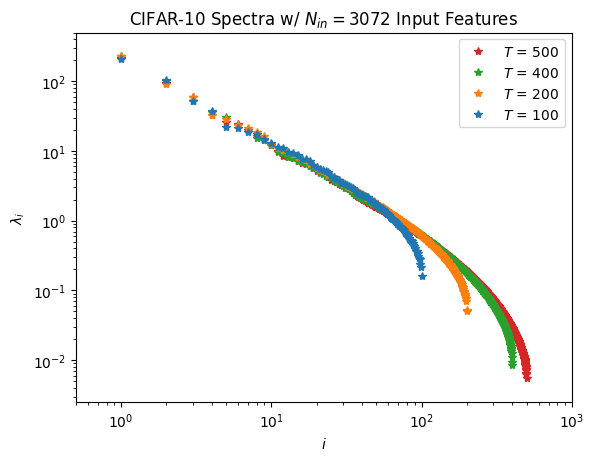

In [ ]:
# %%

"""
This image data is now described by an ordinary design matrix and we can plot the eigenvalue spectrum.
We take a slice of images of size T and then return the x and y values of the eigenvalue data points as a tuple of two lists.
"""

def spec_plot_data(T):
    idx = torch.randint(0, 50000-T+1, (1,)).item()
    data_slice = flat_cifar[idx:idx+T]
    cov = data_slice.transpose(-2, -1) @ data_slice /T
    eiglist = lin.eigvalsh(cov)
    return (range(1, 3072+1), sorted(eiglist)[::-1])

colordict = {100: 'tab:blue', 200: 'tab:orange', 400: 'tab:green', 500: 'tab:red'}

for T in [100, 200, 400, 500][::-1]:
    xdata, ydata = spec_plot_data(T)
    plt.loglog(xdata, ydata, '*', color = colordict[T])
    plt.xlim(.5, 1000)
    plt.ylim(.0025, 500)

plt.legend(["$T$ = " +str(i) for i in [100, 200, 400, 500][::-1]])
plt.title("CIFAR-10 Spectra w/ $N_{in} = 3072$ Input Features")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.show()

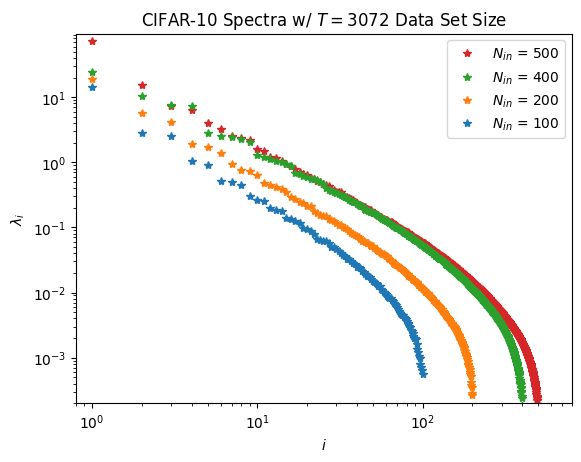

In [ ]:
#%% 

def get_batch(chop_cifar):
    T = 3072
    idx = torch.randint(0, 50000-T+1, (1,)).item()
    return chop_cifar[idx:idx+T]


colordict = {100: 'tab:blue', 200: 'tab:orange', 400: 'tab:green', 500: 'tab:red'}

for N in [100, 200, 400, 500][::-1]:
    nindx = torch.randint(0, 3072-N+1, (1,)).item()
    chop_cifar = flat_cifar.transpose(0, 1)[nindx:nindx+N].transpose(0, 1)
    data_slice = get_batch(chop_cifar)
    cov = data_slice.transpose(-2, -1) @ data_slice /3072
    eiglist = lin.eigvalsh(cov)
    xdata, ydata = (range(1, N+1), sorted(eiglist)[::-1])
    plt.loglog(xdata, ydata, '*', color = colordict[N])
    plt.xlim(.8, 800)
    plt.ylim(.0002, 95)

plt.legend(["$N_{in}$ = " +str(i) for i in [100, 200, 400, 500][::-1]])
plt.title("CIFAR-10 Spectra w/ $T = 3072$ Data Set Size")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.show()

plt.show()

### PCA Analysis

Here we perform PCA analysis on the CIFAR-10 training set. Recall that we have a Hermitian covariance matrix so that for two eigenvectors $e_m$ and $e_n$:
\begin{align*}
e_m \cdot C \cdot e_n = \lambda_n e_m \cdot e_n = e_n \cdot C \cdot e_m = \lambda_m e_n \cdot e_m
\end{align*}
where we supressed component indices and Hermiticity was used to equate the first and third entries. Since $\lambda_m \neq \lambda_n$ this implies orthogonality of the eigenvalues. This means the eigenvalues from PCA furnishes an orthogonal decomposition of the image vector 
\begin{align*}
v = \sum\limits_n \lambda_n (v\cdot e_n)
\end{align*}
we can choose to only keep the $n_{\text{max}}$ most important, sorted by eigenvalue, and see how well the image is reconstructed under truncation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


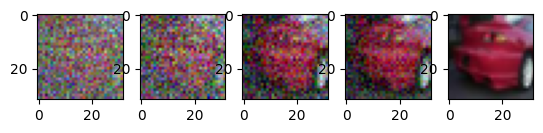

In [ ]:
#%%

"""
More PCA analysis on CIFAR:

While here with CIFAR, we can see what images look like when we reconstruct them only using some of the top principal components.
"""

full_cov = flat_cifar.transpose(-2, -1) @ flat_cifar /len(full_train_data)
eigsystem = lin.eigh(full_cov)

def expansion(flat_img, eig_no):
    return sum([(flat_img @ torch.tensor(eig_vec))*torch.tensor(eig_vec) for eig_vec in eigsystem.eigenvectors[-eig_no:]])

image_idx = 0
component_nums = [750, 1250, 2500, 2750, 3072]
images_out = []
for num in component_nums:
    truncated = expansion(flat_cifar[image_idx ], num)
    images_out.append(np.transpose((truncated.view(3, 32, 32)/2+0.5).numpy(), (1, 2, 0)))


f, axarr = plt.subplots(1,len(component_nums))
for i in range(len(component_nums)):
    axarr[i].imshow(images_out[i])

We can wonder whether perhaps if we were to restrict the covariance matrix to the specific class of image i.e. horse or ship, we might get an improvement with fewer components. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


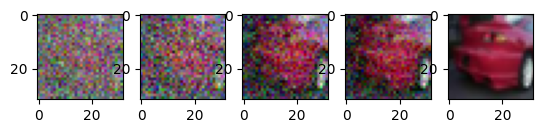

In [ ]:
#%%

"""
Now we check if the performance is any better if we only compute the covariance on the specific animal subspace.
"""

flat_class = torch.stack([flat_cifar[idx] for idx in range(len(flat_cifar)) if classes[full_train_labels[idx]] == classes[full_train_labels[0]]  ])
class_cov = flat_class.transpose(-2, -1) @ flat_class /len(flat_class)
eigsystem = lin.eigh(class_cov)

def expansion(flat_img, eig_no):
    return sum([(flat_img @ torch.tensor(eig_vec))*torch.tensor(eig_vec) for eig_vec in eigsystem.eigenvectors[-eig_no:]])

image_idx = 0
component_nums = [750, 1250, 2500, 2750, 3072]
images_out = []
for num in component_nums:
    truncated = expansion(flat_class[image_idx], num)
    images_out.append(np.transpose((truncated.view(3, 32, 32)/2+0.5).numpy(), (1, 2, 0)))


f, axarr = plt.subplots(1,len(component_nums))
for i in range(len(component_nums)):
    axarr[i].imshow(images_out[i])

### Non-Linearity and Spectral Extension

Another important aspect of the spectrum to understand is spectral extension.

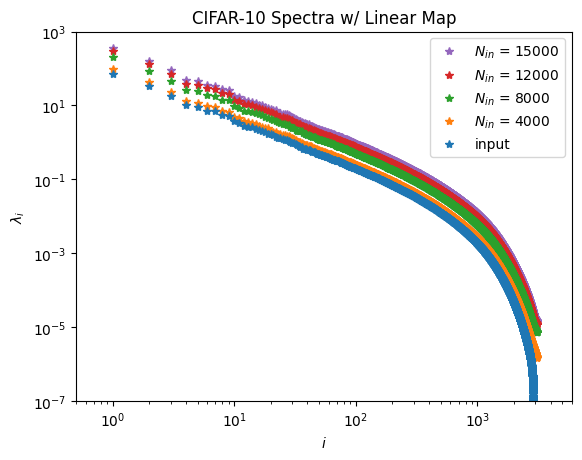

In [ ]:
# %%

def umapcifar(Nout):
    u = nn.Linear(32*32*3, Nout, bias=False)
    return u(flat_cifar)

def u_spec_plot_data(Nout, T):
    idx = torch.randint(0, 50000-T+1, (1,)).item()
    data_slice = umapcifar(Nout)[idx:idx+T]
    cov = data_slice.transpose(-2, -1) @ data_slice /T
    eiglist = lin.eigvalsh(cov.detach().numpy())
    return (range(1, Nout+1)[:3072], sorted(eiglist)[::-1][:3072])

colordict = {3072: 'tab:blue', 4000: 'tab:orange', 8000: 'tab:green', 12000: 'tab:red', 15000: 'tab:purple'}

for Nout in [3072, 4000, 8000, 12000, 15000][::-1]:
    if N == 3072:
        xdata, ydata = spec_plot_data(15000)
    else:
        xdata, ydata = u_spec_plot_data(Nout, 15000)
    plt.loglog(xdata, ydata, '*', color = colordict[Nout])
    plt.xlim(.5, 6000)
    plt.ylim(1e-7, 1000)

plt.legend(["$N_{in}$ = " +str(i) for i in [4000, 8000, 12000, 15000][::-1]]+["input"])
plt.title("CIFAR-10 Spectra w/ Linear Map")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.show()

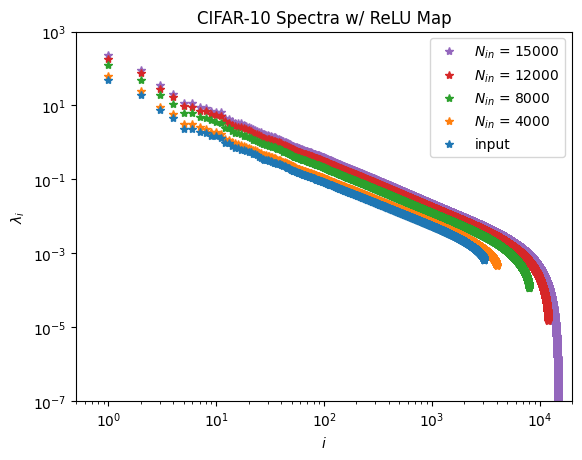

In [ ]:
# %%

def relumapcifar(Nout):
    u = nn.Linear(32*32*3, Nout, bias=False)
    return nn.ReLU()(u(flat_cifar))

def relu_spec_plot_data(Nout, T):
    idx = torch.randint(0, 50000-T+1, (1,)).item()
    data_slice = relumapcifar(Nout)[idx:idx+T]
    cov = data_slice.transpose(-2, -1) @ data_slice /T
    eiglist = lin.eigvalsh(cov.detach().numpy())
    return (range(1, Nout+1), sorted(eiglist)[::-1])

colordict = {3072: 'tab:blue', 4000: 'tab:orange', 8000: 'tab:green', 12000: 'tab:red', 15000: 'tab:purple'}


for Nout in [3072, 4000, 8000, 12000, 15000][::-1]:
    if N == 3072:
        xdata, ydata = spec_plot_data(15000)
    else:
        xdata, ydata = relu_spec_plot_data(Nout, 15000)
    plt.loglog(xdata, ydata, '*', color = colordict[Nout])
    plt.xlim(.5, 20000)
    plt.ylim(1e-7, 1000)



plt.legend(["$N_{in}$ = " +str(i) for i in [4000, 8000, 12000, 15000][::-1]]+["input"])
plt.title("CIFAR-10 Spectra w/ ReLU Map")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.show()